# 1. Setup

## 1.1 Loading libraries

In [1]:
%reload_ext autoreload 
%autoreload 2
import sys, os
sys.path.append("../src/fastai/")
sys.path.append("../src/")

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim

import fastai
from fastai.imports import *
from fastai.conv_learner import *

import numpy as np
import pandas as pd

## 1.2 Inference framework

### 1.2.1 Custom Monte Carlo dropout layer

In [2]:
class DropoutMC(nn.Module):
    r"""
    Modified version of Dropout from torch/nn/modules/dropout.py
    Args:
        p: probability of an element to be zeroed. Default: 0.5
        dropoutMC: If set to ``True``, dropout is turned on at test time. Default: ``True`
        inplace: If set to ``True``, will do this operation in-place. Default: ``False``
    Shape:
        - Input: `Any`. Input can be of any shape
        - Output: `Same`. Output is of the same shape as input
    Examples::
        >>> m = nn.Dropout(p=0.2)
        >>> input = autograd.Variable(torch.randn(20, 16))
        >>> output = m(input)
    .. _Improving neural networks by preventing co-adaptation of feature
        detectors: https://arxiv.org/abs/1207.0580
    """

    def __init__(self, p=0.5, dropoutMC=True, inplace=False):
        super(DropoutMC, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.dropoutMC = dropoutMC
        self.inplace = inplace

    def forward(self, input):
        return F.dropout(input, self.p, self.dropoutMC, self.inplace)

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) \
            + inplace_str + ')'

### 1.2.2 Sampling procedure

In [3]:
def inference(learner, data, T=100):
    ''' Function that gathers all relevant numerical results from MC dropout over T iterations.
        
        Arguments:
        learner, fastai learner object
        data, fastai dataloader
        T, number of stochastic forward passes
    '''
    # Get images, labels and filenames
    imgs, labels = next(iter(data.val_dl))
    fnames = data.val_ds.fnames

    # Empty dictionary to store all output
    output = {}

    # Empty array to store results in
    results = np.empty((T, num_classes))

    # iterator index to keep in dictionary
    k=0

    for (img, label, fname) in list(zip(imgs, labels, fnames)):

        for i in range(T):
            prediction = learner.predict_array(img[None])
            results[i] = prediction

        probs = to_np(F.softmax(V(results)))
        probs_mean = np.mean(probs, axis=0)
        pred_std = np.std(probs, axis=0)

        prediction = probs_mean.argmax()
        uncertainty = pred_std[prediction]

        correct = 1 if prediction == label else 0

        output[k] = {"img": fname, "softmax_dist": probs, "probs": probs_mean, "prediction": prediction, "truth": label, "uncertainty": uncertainty, "correct": correct}
        k+=1
    
    return output

## 1.3 Models

In [4]:
# LeNet architecture (kernel size = 5)
class lenet_all_size5(nn.Module):
    def __init__(self, conv_size=5, pool_size=2, drop_rate=0.5):
        super().__init__()
        self.drop_rate = drop_rate
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=conv_size)
        self.dropmc1 = DropoutMC(p=self.drop_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=2)
        self.conv2 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=conv_size, padding=2)
        self.dropmc2 = DropoutMC(p=self.drop_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=2)
        self.dense1 = nn.Linear(in_features=7*7*192, out_features=1000)
        self.dropmc3 = DropoutMC(p=self.drop_rate)
        self.dense2 = nn.Linear(in_features=1000, out_features=10)
        
    def forward(self, x):
        x = self.dropmc1(self.conv1(x))
        x = self.pool1(x)
        x = self.dropmc2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropmc3(F.relu(self.dense1(x)))
        x = self.dense2(x)
        
        return x
    
# LeNet architecture (kernel size=3)
class lenet_all_size3(nn.Module):
    def __init__(self, conv_size=3, pool_size=2, drop_rate=0.5):
        super().__init__()
        self.drop_rate = drop_rate
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=conv_size)
        self.dropmc1 = DropoutMC(p=self.drop_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=2)
        self.conv2 = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=conv_size, padding=2)
        self.dropmc2 = DropoutMC(p=self.drop_rate)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=2)
        self.dense1 = nn.Linear(in_features=8*8*192, out_features=1000)
        self.dropmc3 = DropoutMC(p=self.drop_rate)
        self.dense2 = nn.Linear(in_features=1000, out_features=10)
        
    def forward(self, x):
        x = self.dropmc1(self.conv1(x))
        x = self.pool1(x)
        x = self.dropmc2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.dropmc3(F.relu(self.dense1(x)))
        x = self.dense2(x)
        
        return x

## 1.4 Helper functions

### 1.4.1 Importing data

In [5]:
def get_data(img_sz, batch_sz, stats):
    # Normalising and augmenting data
    tfms = tfms_from_stats(stats, img_sz, aug_tfms=transforms_side_on)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=batch_sz)

### 1.4.2 Data wrangling

In [53]:
# Turn sampling results into pandas data frame
def get_pd_results(learner, data):
    results = inference(learner, data)
    pd_results = pd.DataFrame(results).T
    return pd_results

# Function for getting highest probability
def get_prob(x):
    return np.sort(x)[-1]

# Function for getting second highest probability
def get_2nd_prob(x):
    return np.sort(x)[-2]

# Function for getting second highest class
def get_2nd_class(x):
    return np.argsort(x)[-2]

# Logit transformation
def logit(x):
    return np.log(x/(1-x))

# Gathering feature engineering in function
def new_features(df):
    new_df = df
    # Getting softmax of predicted class (prob1) and runner-up (prob2), and class of runner-up (class2)
    new_df["prob1"], new_df["prob2"], new_df["class2"]  = new_df["probs"].apply(get_prob), new_df["probs"].apply(get_2nd_prob), new_df["probs"].apply(get_2nd_class)
    # Getting difference in softmax output between predicted class and class with second highest softmax
    new_df["diff"] = new_df["prob1"] - new_df["prob2"]
    # Ratio of difference in softmax outputs/uncertainty estimation for predicted class
    new_df["diff_sd_ratio"] = new_df["diff"]/new_df["uncertainty"]
    # Logit transformation of softmax
    new_df["logit_prob1"] = new_df["prob1"].apply(logit)
    return new_df

# Function preparing data for R analysis
def prepare_R(df):
    return df.drop(columns=["img", "probs", "softmax_dist"])

# Prepare data for plotting
def prepare_img(df):
    return df[["img", "prediction", "softmax_dist", "prob1", "prob2", "class2", "truth", "uncertainty"]]

# Return 5 most uncertain
def most_uncertain(df, status, order):
    return df[df["correct"]==status].sort_values(by="uncertainty", ascending=order)[:5]

### 1.4.3 Plotting

In [54]:
def uncertainty_plots(df, classes, status, order, save=False):
    ''' Function that generates plots including image, scatterplot of softmax values for 
        predicted class and kernel density estimate of distribution of softmax values.
        
        Arguments:
        df, pandas data frame
        classes (str), tuple of class labels
        status (int), 0: incorrect classification or 1: correct classification
        order (bool), False: sort by most uncertain or True: sort by most certain
        '''

    # Getting predictions
    df = most_uncertain(df, status, order)
    df = prepare_img(df)

    # Getting values for each image from each row in df
    for idx, row in df.iterrows():
        file_name = row["img"]
        prediction = row["prediction"]
        dist = row["softmax_dist"]
        pred_mean = row["prob1"]
        p_runnerup = row["prob2"] # Added
        runnerup = row["class2"] # Added
        truth = row["truth"]
        uncertainty = row["uncertainty"]

        # Saving softmax values of predicted class for all 100 iterations
        softmax = []
        for obs in dist:
            softmax.append(obs[prediction])

        # Getting image
        img_path = PATH + "/" + file_name
        img = Image.open(img_path)

        # Creating figure
        fig = plt.figure(figsize=(15,5))

        # Plotting image with true label
        fig.add_subplot(131)
        plt.imshow(img)
        plt.title(f"Label: {classes[truth]}")
        plt.axis("off")

        # Scatterplot of prediction pr. iteration
        fig.add_subplot(132)
        x = range(0, len(softmax))
        plt.scatter(x,softmax)
        if prediction == truth:
            plt.title(f"Prediction: [{classes[prediction]}], Runner-up: [{classes[runnerup]}]", color="g")
        else:
            plt.title(f"Prediction: [{classes[prediction]}], Runner-up: [{classes[runnerup]}]", color="r")
        plt.axhline(pred_mean, color="r", linewidth=1, label="Prediction")
        plt.axhline(p_runnerup, color="sienna", ls="dashed", linewidth=1, label="Runner-up")
        plt.legend(loc='upper left')
        plt.xlabel("iteration")
        plt.ylabel(f"p({prediction}|x,w)")

        # Kernel density plot of ECDF predictions after T forward passes
        fig.add_subplot(133)
        sns.kdeplot(softmax, shade=True, color="b")
        plt.xlim(0,1)
        plt.title("KDE: $\mu$={:.4f}, $\sigma$={:.4f}".format(pred_mean, uncertainty))
        
        if save:
            fig.savefig(f"./figs/{idx}.pdf", bbox_inches="tight")

## 1.5 Importing data

In [55]:
# Path to data
PATH="../../master/DAT259/data/fastai-data/cifar10"

# Class labels
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
num_classes = 10

# Image and batch sizes
img_size = 32
batch_size = 128

# Mean and std. dev. of individual color channels for all CIFAR-10 (taken from Jeremy's notebook)
stats = (np.array([0.4914 ,  0.48216,  0.44653]), np.array([0.24703,  0.24349,  0.26159]))

data = get_data(img_size, batch_size, stats)

# 2. Training

`fastai` provides a wrapper around PyTorch which vastly simplifies the training process. This saves time for simple models such as `lenet-all` (and to a certain extent the predesigned models accompanying PyTorch). For all it's practicality, the `fastai` code is somewhat convoluted and poorly documented. This makes it hard and time-consuming to do other tasks. It is therefore a useful tool for quick prototyping, but for more complicated models and procedures it seems that learning the proper PyTorch approach is well worth the effort.

## 2.1 Model 1: kernel size = 5, drop_rate = 0.5

In [ ]:
# Setting dropout rate
p = 0.5

# Initialising model
model = lenet_all_size5(drop_rate=p)

# Initialising learner
learner = ConvLearner.from_model_data(model, data)

# Setting loss function (fastai default is negative log-likelihood)
learner.crit = nn.CrossEntropyLoss()

# Finding base learning rate
learner.lr_find()
learner.sched.plot()

# The base learning rate and weight decay of the network.
base_lr = 1e-3
weight_decay = 0.0005

# Fitting model and saving best weights
learner.fit(base_lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_p05")
learner.fit(base_lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_p05")

## 2.2 Model 2: kernel size = 5, drop_rate = 0.2

In [ ]:
# Setting dropout rate
p = 0.2

# Initialising model
model = lenet_all_size5(drop_rate=p)

# Initialising learner
learner = ConvLearner.from_model_data(model, data)

# Setting loss function (fastai default is negative log-likelihood)
learner.crit = nn.CrossEntropyLoss()

# Finding base learning rate
learner.lr_find()
learner.sched.plot()

# The base learning rate and weight decay of the network.
base_lr = 1e-2
weight_decay = 0.0005

# Fitting model and saving best weights
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_p02")
learner.fit(1e-4, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_p02")

## 2.3 Model 3: kernel size = 3, drop_rate = 0.5

In [ ]:
# Setting dropout rate
p = 0.5

# Initialising model
model = lenet_all_size3(drop_rate=p)

# Initialising learner
learner = ConvLearner.from_model_data(model, data)

# Setting loss function (fastai default is negative log-likelihood)
learner.crit = nn.CrossEntropyLoss()

# Finding base learning rate
learner.lr_find()
learner.sched.plot()

# The base learning rate and weight decay of the network.
base_lr = 1e-3
weight_decay = 0.0005

# Fitting model and saving best weights
learner.fit(base_lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p05")

## 2.4 Model 4: kernel_size = 3, drop_rate = 0.2

In [ ]:
# Setting dropout rate
p = 0.2

# Initialising model
model = lenet_all_size3(drop_rate=p)

# Initialising learner
learner = ConvLearner.from_model_data(model, data)

# Setting loss function (fastai default is negative log-likelihood)
learner.crit = nn.CrossEntropyLoss()

# Finding base learning rate
learner.lr_find()
learner.sched.plot()

# The base learning rate and weight decay of the network.
base_lr = 1e-3
weight_decay = 0.0005

# Fitting model and saving best weights
learner.fit(base_lr, n_cycle=5, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p02")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p02")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p02")
learner.fit(base_lr, n_cycle=3, cycle_len=1, cycle_mult=2, wds=weight_decay, best_save_name="lenet_all_conv3_p02")

# 3. Inference

In [ ]:
# Initialising models
model_conv5_drop5 = ConvLearner.from_model_data(lenet_all_size5(), data)
model_conv5_drop2 = ConvLearner.from_model_data(lenet_all_size5(drop_rate=0.2), data)
model_conv3_drop5 = ConvLearner.from_model_data(lenet_all_size3(), data)
model_conv3_drop2 = ConvLearner.from_model_data(lenet_all_size3(drop_rate=0.2), data)

# Loading pretrained weights
model_conv5_drop5.load("lenet_all_p05")
model_conv5_drop2.load("lenet_all_p02")
model_conv3_drop5.load("lenet_all_conv3_p05")
model_conv3_drop2.load("lenet_all_conv3_p02")

In [ ]:
# Performing inference and pickling results
results_df1 = get_pd_results(model_conv5_drop5, data_test)
results_df1.to_pickle("model_conv5_drop5-v2.pkl")

results_df2 = get_pd_results(model_conv5_drop2, data_test)
results_df2.to_pickle("model_conv5_drop2-v2.pkl")

results_df3 = get_pd_results(model_conv3_drop5, data_test)
results_df3.to_pickle("model_conv3_drop5-v2.pkl")

results_df4 = get_pd_results(model_conv3_drop2, data_test)
results_df4.to_pickle("model_conv3_drop2-v2.pkl")

In [93]:
# For notebook, delete after
df = pd.read_pickle("model_conv5_drop5-v2.pkl")

In [94]:
df["correct"].mean()

0.7916

In [95]:
df = new_features(df)

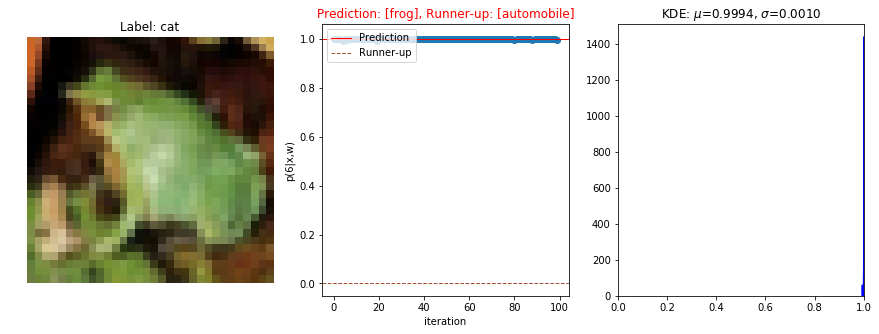

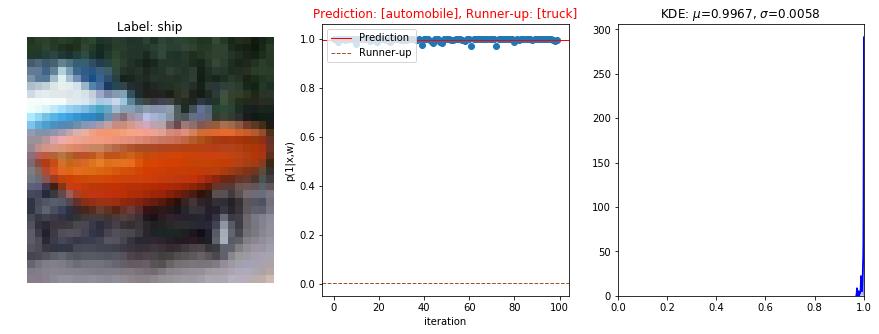

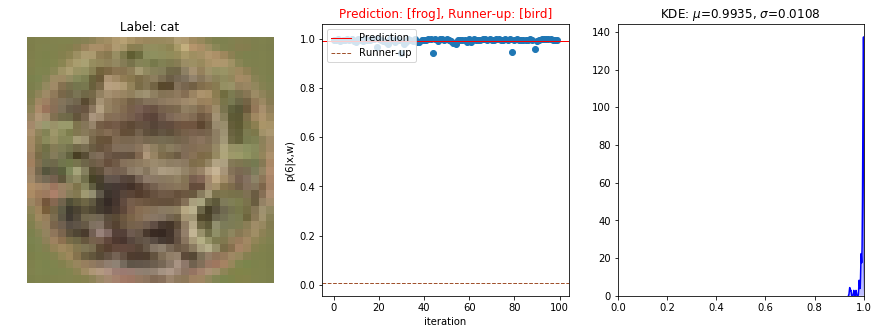

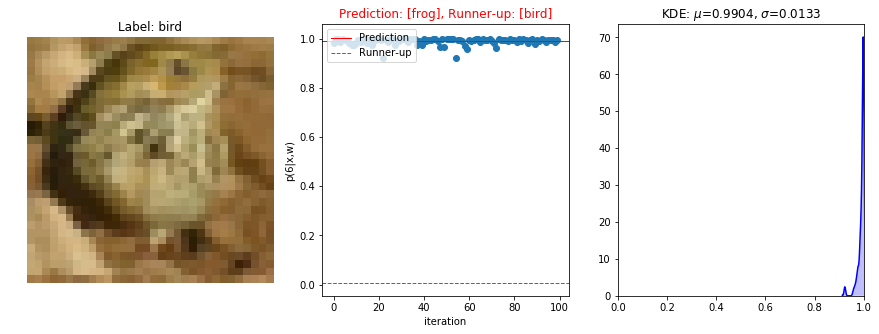

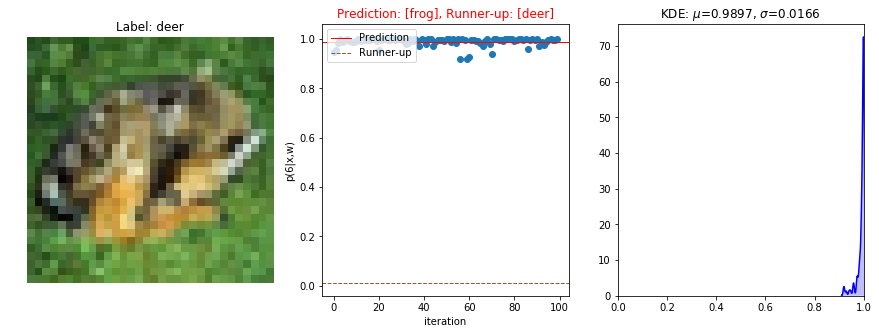

In [106]:
uncertainty_plots(df, classes, 0, True, save=False)

Testing to see if repeating "airplane" class is a bug:

In [97]:
top5=df[df["correct"]==1].sort_values(by="uncertainty", ascending=False)[:5]

In [98]:
top5

,correct,img,prediction,probs,softmax_dist,truth,uncertainty,prob1,prob2,class2,diff,diff_sd_ratio,logit_prob1
2579,1,test/bird/731_bird.png,2,"[0.4564106, 0.012624463, 0.46159545, 1.8627896...","[[0.6141072, 0.02177256, 0.101749055, 4.429490...",2,0.352633,0.461595,0.456411,0,0.005185,0.0147033,-0.153921
9468,1,test/truck/4193_truck.png,9,"[0.37291282, 0.03668362, 0.018566258, 0.001169...","[[0.02885471, 0.0010370634, 9.734754e-05, 2.63...",9,0.33266,0.540122,0.372913,0,0.167210,0.502645,0.160836
8169,1,test/ship/9784_ship.png,8,"[0.46758205, 2.2973134e-05, 0.00035673397, 2.0...","[[0.40769383, 3.832481e-06, 3.178131e-05, 2.59...",8,0.329534,0.531983,0.467582,0,0.064401,0.195429,0.128106
7778,1,test/horse/9149_horse.png,7,"[0.26802728, 0.021124488, 0.0006214593, 0.0014...","[[0.20538743, 0.0006747431, 2.945917e-06, 0.00...",7,0.326924,0.501240,0.268027,0,0.233213,0.713354,0.004960
1079,1,test/automobile/4799_automobile.png,1,"[0.18635777, 0.5211758, 9.2683134e-05, 0.00010...","[[0.070814, 0.02002063, 0.0003656098, 0.000154...",1,0.313575,0.521176,0.186358,0,0.334818,1.06774,0.084754


In [105]:
for i in range(5):
    print(top5["probs"].iloc[i])
    print(top5["probs"].iloc[i].argmax())

[0.45641 0.01262 0.4616  0.00002 0.      0.      0.00722 0.      0.06213 0.     ]
2
[0.37291 0.03668 0.01857 0.00117 0.00001 0.00001 0.      0.      0.03053 0.54012]
9
[0.46758 0.00002 0.00036 0.      0.      0.      0.      0.      0.53198 0.00005]
8
[0.26803 0.02112 0.00062 0.00145 0.00252 0.00086 0.      0.50124 0.00757 0.19659]
7
[0.18636 0.52118 0.00009 0.0001  0.00001 0.      0.      0.00061 0.17252 0.11913]
1


In [ ]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")